# Flight Delays

In [17]:
import pandas as pd
import glob
import os
import requests
import json
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import random
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Business Understanding

MVP should support:

* [Top 8 US Airlines](https://www.statista.com/statistics/250577/domestic-market-share-of-leading-us-airlines/)
 * American Airlines
 * Delta Air Lines
 * United Airlines
 * Southwest Airlines
 * Alaska Airlines
 * JetBlue Airways
 * Spirit
 * SkyWest
* [Large and medium airport hubs](https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/media/cy20-commercial-service-enplanements.pdf)
 * "The term hub is used by the FAA to identify very busy commercial service airports. Large hubs are the airports that each account for at least one percent of total U.S. passenger enplanements."
 * In 2020 these accounted for 84% of all enplanements


### Airports
| State | Locid | City                  | Airport Name                                           | CY 20 Enplanements |
|-------|-------|-----------------------|--------------------------------------------------------|--------------------|
| GA    | ATL   | Atlanta               | Hartsfield - Jackson Atlanta International             |         20,559,866 |
| TX    | DFW   | Fort Worth            | Dallas-Fort Worth International                        |         18,593,421 |
| CO    | DEN   | Denver                | Denver International                                   |         16,243,216 |
| IL    | ORD   | Chicago               | Chicago O'Hare International                           |         14,606,034 |
| CA    | LAX   | Los Angeles           | Los Angeles International                              |         14,055,777 |
| NC    | CLT   | Charlotte             | Charlotte/Douglas International                        |         12,952,869 |
| NV    | LAS   | Las Vegas             | Harry Reid International                               |         10,584,059 |
| AZ    | PHX   | Phoenix               | Phoenix Sky Harbor International                       |         10,531,436 |
| FL    | MCO   | Orlando               | Orlando International                                  |         10,467,728 |
| WA    | SEA   | Seattle               | Seattle-Tacoma International                           |          9,462,411 |
| FL    | MIA   | Miami                 | Miami International                                    |          8,786,007 |
| TX    | IAH   | Houston               | George Bush Intcntl/Houston                            |          8,682,558 |
| NY    | JFK   | New York              | John F Kennedy International                           |          8,269,819 |
| FL    | FLL   | Fort Lauderdale       | Fort Lauderdale/Hollywood International                |          8,015,744 |
| NJ    | EWR   | Newark                | Newark Liberty International                           |          7,985,474 |
| CA    | SFO   | San Francisco         | San Francisco International                            |          7,745,057 |
| MN    | MSP   | Minneapolis           | Minneapolis-St Paul International/Wold-  Chamberlain   |          7,069,720 |
| MI    | DTW   | Detroit               | Detroit Metro Wayne County                             |          6,822,324 |
| MA    | BOS   | Boston                | General Edward Lawrence Logan   International          |          6,035,452 |
| UT    | SLC   | Salt Lake City        | Salt Lake City International                           |          5,981,032 |
| PA    | PHL   | Philadelphia          | Philadelphia International                             |          5,753,239 |
| MD    | BWI   | Glen Burnie           | Baltimore/Washington International   Thurgood Marshall |          5,451,355 |
| FL    | TPA   | Tampa                 | Tampa International                                    |          4,966,775 |
| CA    | SAN   | San Diego             | San Diego International                                |          4,637,856 |
| IL    | MDW   | Chicago               | Chicago Midway International                           |          4,236,603 |
| NY    | LGA   | New York              | Laguardia                                              |          4,147,116 |
| TN    | BNA   | Nashville             | Nashville International                                |          4,013,995 |
| VA    | IAD   | Dulles                | Washington Dulles International                        |          3,862,658 |
| TX    |   DAL | Dallas                | Dallas Love Field                                      |          3,669,930 |
| VA    | DCA   | Arlington             | Ronald Reagan Washington Ntl                           |          3,573,489 |
| OR    | PDX   | Portland              | Portland International                                 |          3,455,877 |
| TX    | AUS   | Austin                | Austin-Bergstrom International                         |          3,141,505 |
| TX    | HOU   | Houston               | William P Hobby                                        |          3,127,178 |
| HI    | HNL   | Honolulu              | Daniel K Inouye International                          |          3,126,391 |
| MO    | STL   | St. Louis             | St Louis Lambert International                         |          3,041,765 |
| FL    | RSW   | Fort Myers            | Southwest Florida International                        |          2,947,139 |
| CA    | SMF   | Sacramento            | Sacramento International                               |          2,710,342 |
| LA    | MSY   | New Orleans -  Kenner | Louis Armstrong New Orleans   International            |          2,632,606 |
| PR    | SJU   | San Juan              | Luis Munoz Marin International                         |          2,362,851 |
| NC    | RDU   | Raleigh               | Raleigh-Durham International                           |          2,337,496 |
| CA    | SJC   | San Jose              | Norman Y Mineta San Jose International                 |          2,283,186 |
| CA    | OAK   | Oakland               | Metro Oakland International                            |          2,271,294 |
| MO    | MCI   | Kansas City           | Kansas City International                              |          2,167,616 |
| OH    | CLE   | Cleveland             | Cleveland-Hopkins International                        |          1,990,156 |
| IN    | IND   | Indianapolis          | Indianapolis International                             |          1,989,126 |
| TX    | SAT   | San Antonio           | San Antonio International                              |          1,919,958 |
| CA    | SNA   | Santa Ana             | John Wayne/Orange County                               |          1,824,836 |
| PA    | PIT   | Pittsburgh            | Pittsburgh International                               |          1,742,406 |
| KY    | CVG   | Hebron                | Cincinnati/Northern Kentucky   International           |          1,729,395 |
| OH    | CMH   | Columbus              | John Glenn Columbus International                      |          1,577,596 |
| FL    | PBI   | West Palm   Beach     | Palm Beach International                               |          1,518,732 |
| FL    | JAX   | Jacksonville          | Jacksonville International                             |          1,367,501 |
| WI    | MKE   | Milwaukee             | General Mitchell International                         |          1,263,385 |
| CA    | ONT   | Ontario               | Ontario International                                  |          1,237,946 |
| AK    | ANC   | Anchorage             | Ted Stevens Anchorage International                    |          1,157,301 |
| CT    | BDL   | Windsor Locks         | Bradley International                                  |          1,150,033 |
| HI    | OGG   | Kahului               | Kahului                                                |          1,135,141 |
| CA    | BUR   | Burbank               | Bob Hope                                               |          1,056,838 |
| NE    | OMA   | Omaha                 | Eppley Airfield                                        |          1,036,245 |
| TN    | MEM   | Memphis               | Memphis International                                  |          1,015,981 |
| ID    | BOI   | Boise                 | Boise Air Trml/Gowen Field                             |            991,241 |
| NV    | RNO   | Reno                  | Reno/Tahoe International                               |            976,937 |
| SC    | CHS   | Charleston            | Charleston AFB/International                           |            944,660 |
| OK    | OKC   | Oklahoma City         | Will Rogers World                                      |            934,842 |

## Data

In [2]:
# flight_data = glob.glob(os.path.join('data/flights/', "*.csv"))

# df = pd.concat((pd.read_csv(f) for f in flight_data), ignore_index=True)

# df['FL_DATE'] = df['FL_DATE'].astype('datetime64[ns]')

In [16]:
# df.loc[df['ORIGIN'] == 'JFK']['TAIL_NUM'].value_counts()

N113AN    1011
N109NN     947
N104NN     939
N108NN     931
N101NN     931
          ... 
N226JS       1
N621AE       1
N57852       1
N77865       1
N522AE       1
Name: TAIL_NUM, Length: 3013, dtype: int64

In [17]:
# df.loc[df['TAIL_NUM'] == 'N113AN'].sort_values('FL_DATE')[['ORIGIN', 'DEST', 'FL_DATE', 'CRS_DEP_TIME']].head(50)

,ORIGIN,DEST,FL_DATE,CRS_DEP_TIME
19859464,LAX,JFK,2018-08-01,1130
19862529,JFK,LAX,2018-08-01,2130
19860246,JFK,LAX,2018-08-01,700
19861268,JFK,LAX,2018-08-02,1700
19860968,LAX,JFK,2018-08-02,700
19862384,JFK,SFO,2018-08-03,2000
19864969,LAX,JFK,2018-08-03,800
19862145,SFO,JFK,2018-08-04,800
19860032,LAX,JFK,2018-08-04,2230
19864847,JFK,LAX,2018-08-04,1800


| Field               | Description                                                                                                                                                         |
|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| YEAR                | Year                                                                                                                                                                |
| MONTH               | Month                                                                                                                                                               |
| DAY_OF_WEEK         | Day of Week                                                                                                                                                         |
| FL_DATE             | Flight Date (yyyymmdd)                                                                                                                                              |
| MKT_UNIQUE_CARRIER  | Unique Marketing Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2).    |
| MKT_CARRIER_FL_NUM  | Flight Number                                                                                                                                                       |
| OP_UNIQUE_CARRIER   | Flight NumberUnique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2)  |
| ORIGIN              | Origin Airport                                                                                                                                                     |
| ORIGIN_WAC          | Origin Airport, World Area Code                                                                                                                                     |
| DEST                | Destination Airport                                                                                                                                                |
| DEST_WAC            | Destination Airport, World Area Code                                                                                                                                |
| CRS_DEP_TIME        | CRS Departure Time (local time: hhmm)                                                                                                                               |
| DEP_TIME            | Actual Departure Time (local time: hhmm)                                                                                                                            |
| DEP_DELAY_NEW       | Difference in minutes between scheduled and actual departure time. Early departures set to 0.                                                                       |
| TAXI_OUT            | Taxi Out Time, in Minutes                                                                                                                                           |
| TAXI_IN             | Taxi In Time, in Minutes                                                                                                                                            |
| CRS_ARR_TIME        | CRS Arrival Time (local time: hhmm)                                                                                                                                 |
| ARR_TIME            | Actual Arrival Time (local time: hhmm)                                                                                                                              |
| ARR_DELAY_NEW       | Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0.                                                                           |
| CARRIER_DELAY       | Carrier Delay, in Minutes                                                                                                                                           |
| WEATHER_DELAY       | Weather Delay, in Minutes                                                                                                                                           |
| NAS_DELAY           | National Air System Delay, in Minutes                                                                                                                               |
| SECURITY_DELAY      | Security Delay, in Minutes                                                                                                                                         |
| LATE_AIRCRAFT_DELAY | Late Aircraft Delay, in Minutes                                                                                                                                    |


### Estimating flight volume

A useful metric to estimate delays may be "traffic". There are a few measures of traffic that may be interesting to look at.

* Traffic in the hour a particular flight is scheduled to depart.
* Traffic in the last hour
* Traffic that day

In [3]:
# # First, we need to clean up the time field so that it's easier to work with
# # The dataset stores time as a float, and we want to conver it to a datetime format

# def float_to_time(time):
#     time_str = str(time)
#     digits = len(time_str)
#     if digits < 2:
#         return '00:0' + str(time)
#     if digits == 2:
#         return '00:' + str(time)
#     if digits == 3:
#         return '0' + time_str[:1] + ':' + time_str[1:]
#     if digits == 4:
#         return time_str[:2] + ':' + time_str[2:]
    
    
# # Dealing with time is tricky since flights can depart at odd times/horus. To simplify, we'll round the takeoff times.

# def hour_rounder(t):
#     # Rounds to nearest hour by adding a timedelta hour if minute >= 30
#     return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
#                +timedelta(hours=t.minute//30))

In [4]:
# df['scheduled-takeoff-time'] = df['CRS_DEP_TIME'].apply(float_to_time)
# df['scheduled-takeoff'] =  pd.to_datetime(df['FL_DATE'].astype(str) + ' ' + df['scheduled-takeoff-time'])

In [5]:
# df['rounded-takeoff'] = df['scheduled-takeoff'].apply(hour_rounder)
# df['rounded-takeoff-minus-one-hour'] = df['rounded-takeoff'] - timedelta(hours=0, minutes=60)
# df['take-off-rounded-hour'] = df['rounded-takeoff'].dt.hour
# df['take-off-rounded-hour-minus-one'] = df['rounded-takeoff-minus-one-hour'].dt.hour

In [6]:
# df['congestion-at-takeoff-key'] = df['ORIGIN'] \
#                                       + df['MONTH'].astype(str) \
#                                       + df['DAY_OF_MONTH'].astype(str) \
#                                       + df['take-off-rounded-hour'].astype(str)

# df['congestion-before-takeoff-key'] = df['ORIGIN'] \
#                                       + df['MONTH'].astype(str) \
#                                       + df['DAY_OF_MONTH'].astype(str) \
#                                       + df['take-off-rounded-hour-minus-one'].astype(str)

# df['congestion-day-of-key'] = df['ORIGIN'] \
#                                       + df['MONTH'].astype(str) \
#                                       + df['DAY_OF_MONTH'].astype(str)

In [7]:
# flight_counts_at_takehoff = df.groupby('congestion-at-takeoff-key')['TAIL_NUM'].count()
# flight_counts_at_takehoff = flight_counts_at_takehoff.to_frame()
# flight_counts_at_takehoff.reset_index(inplace=True)
# flight_counts_at_takehoff.rename(columns={'congestion-at-takeoff-key': 'congestion-at-takeoff-key',
#                                           'TAIL_NUM': 'count_flights_at_takeoff'},
#                                            inplace=True)

# flight_counts_before_takeoff = df.groupby('congestion-before-takeoff-key')['TAIL_NUM'].count()
# flight_counts_before_takeoff = flight_counts_before_takeoff.to_frame()
# flight_counts_before_takeoff.reset_index(inplace=True)
# flight_counts_before_takeoff.rename(columns={'congestion-before-takeoff-key': 'congestion-before-takeoff-key',
#                                              'TAIL_NUM': 'count_flights_before'},
#                                               inplace=True)


# flight_counts_day_of_takeoff = df.groupby('congestion-day-of-key')['TAIL_NUM'].count()
# flight_counts_day_of_takeoff = flight_counts_day_of_takeoff.to_frame()
# flight_counts_day_of_takeoff.reset_index(inplace=True)
# flight_counts_day_of_takeoff.rename(columns={'congestion-day-of-key': 'congestion-day-of-key',
#                                              'TAIL_NUM': 'count_flights_day'},
#                                               inplace=True)

# flight_counts_at_takehoff['avg-flights-at-takeoff'] = flight_counts_at_takehoff['count_flights_at_takeoff'] / 3
# flight_counts_before_takeoff['avg-flights-before-takeoff'] = flight_counts_before_takeoff['count_flights_before'] / 3
# flight_counts_day_of_takeoff['avg-flights-day-of-takeoff'] = flight_counts_day_of_takeoff['count_flights_day'] / 3

# df = df.merge(flight_counts_at_takehoff, on='congestion-at-takeoff-key')
# df = df.merge(flight_counts_before_takeoff, on='congestion-before-takeoff-key')
# df = df.merge(flight_counts_day_of_takeoff, on='congestion-day-of-key')

## How many stops does a plane make in a 48 hour period?

In [8]:
# # Let's check, on average, how many unique origins a plane goes through in a day
# df['month-day-tail'] = df['MONTH'].astype(str) + df['DAY_OF_MONTH'].astype(str) + df['YEAR'].astype(str) + df['TAIL_NUM']
# df.groupby('month-day-tail')[['ORIGIN', 'DEST']].nunique().describe()

,ORIGIN,DEST
count,5.798893e+06,5.798893e+06
mean,3.375936e+00,3.384057e+00
std,1.454625e+00,1.462599e+00
min,1.000000e+00,1.000000e+00
25%,2.000000e+00,2.000000e+00
50%,3.000000e+00,3.000000e+00
75%,4.000000e+00,4.000000e+00
max,2.800000e+01,3.000000e+01


Looks like, on average, a single tail number appears at 3 unique locations within a single day.

So when we do our analysis, we will want to examine flight data for a record plus it's last 2 stops.

In [9]:
# def categorise(row):  
#     if row['origin_1_hop_back'] == row['ORIGIN']:
#         return row['dest_1_hop_back']
#     else:
#         return row['origin_1_hop_back']

In [10]:
# # Get previous airport & date/time
# df.sort_values('FL_DATE', inplace=True)

# # 1 hop back
# df['origin_1_hop_back'] = df.groupby('TAIL_NUM')['ORIGIN'].shift(periods=1, fill_value=0)
# df['dest_1_hop_back'] = df.groupby('TAIL_NUM')['DEST'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back'] = df.apply(lambda row: categorise(row), axis=1)
# df['airport_1_hop_back_date'] = df.groupby('TAIL_NUM')['FL_DATE'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_flight_vol_takoff'] = df.groupby('TAIL_NUM')['avg-flights-at-takeoff'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_flight_vol_before_takoff'] = df.groupby('TAIL_NUM')['avg-flights-before-takeoff'].shift(periods=1, fill_value=0)
# df['airport_1_hop_back_flight_vol_day_of_takoff'] = df.groupby('TAIL_NUM')['avg-flights-day-of-takeoff'].shift(periods=1, fill_value=0)

# # 2 hops back
# df['airport_2_hop_back'] = df.groupby('TAIL_NUM')['ORIGIN'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_date'] = df.groupby('TAIL_NUM')['FL_DATE'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_flight_vol_takoff'] = df.groupby('TAIL_NUM')['avg-flights-at-takeoff'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_flight_vol_before_takoff'] = df.groupby('TAIL_NUM')['avg-flights-before-takeoff'].shift(periods=2, fill_value=0)
# df['airport_2_hop_back_flight_vol_day_of_takoff'] = df.groupby('TAIL_NUM')['avg-flights-day-of-takeoff'].shift(periods=2, fill_value=0)

In [11]:
# filtered_df = df.loc[(df['airport_1_hop_back'] != 0) & (df['airport_2_hop_back'] != 0)]

In [5]:
# Create list of relevant aiports based on business case
relevant_airports = ['ATL', 'DFW', 'DEN', 'ORD', 'LAX', 'CLT', 'LAS', 'PHX', 
                     'MCO', 'SEA', 'MIA', 'IAH', 'JFK', 'FLL', 'EWR', 'SFO', 'MSP', 'DTW',
                     'BOS', 'SLC', 'PHL', 'BWI', 'TPA', 'SAN', 'MDW', 'LGA', 'BNA', 'IAD',
                     'DAL', 'DCA', 'PDX', 'AUS', 'HOU', 'HNL', 'STL', 'RSW', 'SMF', 'MSY',
                     'SJU', 'RDU', 'OAK', 'MCI', 'CLE', 'IND', 'SAT', 'SNA', 'PIT', 'CVG',
                     'CMH', 'PBI', 'JAX', 'MKE', 'ONT', 'ANC', 'BDL', 'OGG', 'OMA', 'MEM',
                     'BOI', 'RNO', 'CHS', 'OKC']

# Create list of relevant IATA airline designators based on business case
relevant_airlines = ['WN', # Southwest
                     'DL', # Delta
                     'OO', # SkyWest
                     'AA', # American Airlines
                     'UA', # United Airlines
                     'B6', # JetBlue
                     'AS', # Alaska Airlines
                     'NK', # Spirit Airlines
                    ]

# # Filter Dataframe to include only relevant airlines & airports
# airport_filter = '|'.join(relevant_airports)
# airline_filter = '|'.join(relevant_airlines)

# df_origin_filtered = filtered_df[pd.notna(filtered_df['ORIGIN']) & filtered_df['ORIGIN'].str.contains(airport_filter)
#                                  & filtered_df['airport_1_hop_back'].str.contains(airport_filter)
#                                  & filtered_df['DEST'].str.contains(airport_filter)
#                                  & filtered_df['airport_2_hop_back'].str.contains(airport_filter)]

# df_carrier_filtered = df_origin_filtered[pd.notna(df_origin_filtered['OP_CARRIER']) & 
#                                          df_origin_filtered['OP_CARRIER'].str.contains(airline_filter)]

# df_carrier_filtered.to_csv('data/filtered_airport_data.csv')

In [3]:
# df_carrier_filtered =  pd.read_csv('data/filtered_airport_data.csv')

### What causes delays?
Here is a list of delay causes since 2018 as reported by the [Bureau of Transportation Statistics (BTS)](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations).

| Year    | Air Carrier Delay (%) | Aircraft Arriving Late (%) | National Aviation System Delay (%) | Security Delay (%) | Extreme Weather (%) |
|---------|:---------------------:|:--------------------------:|:----------------------------------:|:------------------:|:-------------------:|
| 2018    |           30          |             40             |                 25                 |        0.10        |          6          |
| 2019    |           31          |             40             |                 24                 |        0.10        |          6          |
| 2020    |           41          |             30             |                 22                 |        0.20        |          7          |
| Average |           34          |             37             |                 23                 |        0.13        |          6          |

The breakout provided by the Bureau of Transportation Statistics is a little misleading when it comes to delays caused by weather. They explain it:

"There is another category of weather within the [National Aviation System Delay] category. This type of weather slows the operations of the system but does not prevent flying. Delays or cancellations coded "NAS" are the type of weather delays that could be reduced with corrective action by the airports or the Federal Aviation Administration. During 2020, 45.8% of NAS delays were due to weather."

"A true picture of total weather-related delays requires several steps. First, the extreme weather delays must be combined with the NAS weather category. Second, a calculation must be made to determine the weather-related delays included in the "late-arriving aircraft" category. Airlines do not report the causes of the late-arriving aircraft but an allocation can be made using the proportion of weather related-delays and total flights in the other categories."

| Year    | Weather Related Delays |
|---------|------------------------|
| 2018    |           38           |
| 2019    |           39           |
| 2020    |           29           |
| 2021    |           27           |
| Average |           33           |

Given the importance of weather as a delay factor, we will work to bring in weather data into our analysis.

### Bringing in Weather Data

One of the best sources of data is the National Oceanic and Atmospheric Administration (NOAA). It has weather stations all over the United States which collect weather data. This data can then be downloaded through their API.

We'll work to link NOAA weather data at the scheduled departure time for each flight.

We will be looking for the following weather stats:
* Temperature
* Precipitation
* Surface wind
* Ceiling & Visibility
 * Ceiling: The height above the earth's surface of the lowest layer reported as broken or overcast, or as the vertical visibility into an indefinite ceiling
 * Visibility: the vertical distance that an observer or some remote sensing device can see into a cloud
 
Data from NOAA by weather station is available [here](https://www.ncei.noaa.gov/data/normals-hourly/2006-2020/access/).

|                                         Airport Name |  Station ID |
|-----------------------------------------------------:|------------:|
|           Hartsfield - Jackson Atlanta International | USW00013874 |
|                      Dallas-Fort Worth International | USW00003927 |
|                                 Denver International | USW00003017 |
|                         Chicago O'Hare International | USW00094846 |
|                            Los Angeles International | USW00023174 |
|                      Charlotte/Douglas International | USW00013881 |
|                             Harry Reid International | USW00023169 |
|                     Phoenix Sky Harbor International | USW00023183 |
|                                Orlando International | USW00012815 |
|                         Seattle-Tacoma International | USW00024233 |
|                                  Miami International | USW00012839 |
|                          George Bush Intcntl/Houston | USW00012960 |
|                         John F Kennedy International | USW00094789 |
|              Fort Lauderdale/Hollywood International | USW00012849 |
|                         Newark Liberty International | USW00014734 |
|                          San Francisco International | USW00023234 |
|  Minneapolis-St Paul International/Wold- Chamberlain | USW00014922 |
|                           Detroit Metro Wayne County | USW00094847 |
|          General Edward Lawrence Logan International | USW00014739 |
|                         Salt Lake City International | USW00024127 |
|                           Philadelphia International | USW00013739 |
| Baltimore/Washington International Thurgood Marshall | USW00093721 |
|                                  Tampa International | USW00012842 |
|                              San Diego International | USW00023188 |
|                         Chicago Midway International | USW00014819 |
|                                            Laguardia | USW00014732 |
|                              Nashville International | USW00013897 |
|                      Washington Dulles International | USW00093738 |
|                                    Dallas Love Field | USW00013960 |
|                         Ronald Reagan Washington Ntl | USW00013743 |
|                               Portland International | USW00024229 |
|                       Austin-Bergstrom International | USW00013904 |
|                                      William P Hobby | USW00012918 |
|                        Daniel K Inouye International | USW00022521 |
|                       St Louis Lambert International | USW00013994 |
|                      Southwest Florida International | USW00012835 |
|                             Sacramento International | USW00023232 |
|            Louis Armstrong New Orleans International | USW00012916 |
|                       Luis Munoz Marin International | USW00022010 |
|                         Raleigh-Durham International | USW00013722 |
|                          Metro Oakland International | USW00023230 |
|                            Kansas City International | USW00003947 |
|                      Cleveland-Hopkins International | USW00014820 |
|                           Indianapolis International | USW00093819 |
|                            San Antonio International | USW00012921 |
|                             John Wayne/Orange County | USW00093184 |
|                             Pittsburgh International | USW00094823 |
|           Cincinnati/Northern Kentucky International | USW00093814 |
|                    John Glenn Columbus International | USW00014821 |
|                             Palm Beach International | USW00012844 |
|                           Jacksonville International | USW00013889 |
|                       General Mitchell International | USW00014839 |
|                                Ontario International | USW00003102 |
|                  Ted Stevens Anchorage International | USW00026451 |
|                                Bradley International | USW00014740 |
|                                              Kahului | USW00022516 |
|                                      Eppley Airfield | USW00014942 |
|                                Memphis International | USW00013893 |
|                           Boise Air Trml/Gowen Field | USW00024131 |
|                             Reno/Tahoe International | USW00023185 |
|                         Charleston AFB/International | USW00013880 |
|                                    Will Rogers World | USW00013967 |

In [13]:
# def get_keys(path):
#     with open(path) as f:
#         return json.load(f)
    
# keys = get_keys("C:/Users/Robert/.secret/noaa_api.json")

# api_key = keys['api_key']

# import time

# weather_stations = {}

# for i in station_list:
#     weather_stations[i] = {'DATE': [], 'TAVG': [], 'SNOW': [], 'PRCP': [], 'AWND': []}

# for year in range(2018, 2022):
#     year = str(year)
#     for station in weather_stations:
#         current_station = str(station)
#         print('Working on year: '+year +' and station: '+ current_station)
#         #make the api call
#         time.sleep(1)
#         r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,SNOW,PRCP,AWND&limit=1000&stationid=GHCND:'+current_station+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':api_key})
#         r2 = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG,SNOW,PRCP,AWND&offset=1001&limit=1000&stationid=GHCND:'+current_station+'&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':api_key})
#         #load the api response as a json
#         d = json.loads(r.text)
#         d2 = json.loads(r2.text)
#         #get all items in the response which are average temperature readings
#         avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
#         if bool(d2):
#             avg_temps2 = [item for item in d2['results'] if item['datatype']=='TAVG']
#         #get the date field from these readings
#         weather_stations[current_station]['DATE'] += [item['date'] for item in avg_temps]
#         if bool(d2):
#             weather_stations[current_station]['DATE'] += [item['date'] for item in avg_temps2]
#         #get the actual average temperature from all average temperature readings
#         weather_stations[current_station]['TAVG'] += [item['value'] for item in avg_temps]
#         if bool(d2):
#             weather_stations[current_station]['TAVG'] += [item['value'] for item in avg_temps2]
#         #get all items in the response which are Snowfall (mm)
#         snowfall = [item for item in d['results'] if item['datatype']=='SNOW']
#         if bool(d2):
#             snowfall2 = [item for item in d2['results'] if item['datatype']=='SNOW']
#         #get the actual Snowfall readings
#         weather_stations[current_station]['SNOW'] += [item['value'] for item in snowfall]
#         if bool(d2):
#             weather_stations[current_station]['SNOW'] += [item['value'] for item in snowfall2]
#         #get all items in the response Precipitation (tenths of mm)
#         precipitation = [item for item in d['results'] if item['datatype']=='PRCP']
#         if bool(d2):
#             precipitation2 = [item for item in d2['results'] if item['datatype']=='PRCP']
#         #get the actual Precipitation from all Precipitation readings
#         weather_stations[current_station]['PRCP'] += [item['value'] for item in precipitation]
#         if bool(d2):
#             weather_stations[current_station]['PRCP'] += [item['value'] for item in precipitation2]
#         # Average daily wind speed (tenths of meters per second)
#         windspeed = [item for item in d['results'] if item['datatype']=='AWND']
#         if bool(d2):
#             windspeed2 = [item for item in d2['results'] if item['datatype']=='AWND']
#         #get the Average daily wind speed from all average temperature readings
#         weather_stations[current_station]['AWND'] += [item['value'] for item in windspeed]
#         if bool(d2):
#              weather_stations[current_station]['AWND'] += [item['value'] for item in windspeed2]

In [6]:
# # List of Station IDs
# station_list = ['USW00013874', 'USW00003927', 'USW00003017', 'USW00094846',
#                 'USW00023174','USW00013881','USW00023169','USW00023183',
#                 'USW00012815','USW00024233','USW00012839','USW00012960',
#                 'USW00094789','USW00012849','USW00014734','USW00023234',
#                 'USW00014922','USW00094847','USW00014739','USW00024127',
#                 'USW00013739','USW00093721','USW00012842','USW00023188',
#                 'USW00014819','USW00014732','USW00013897','USW00093738',
#                 'USW00013960','USW00013743','USW00024229','USW00013904',
#                 'USW00012918','USW00022521','USW00013994','USW00012835',
#                 'USW00023232','USW00012916','USW00022010','USW00013722',
#                 'USW00023230','USW00003947','USW00014820','USW00093819',
#                 'USW00012921','USW00093184','USW00094823','USW00093814',
#                 'USW00014821','USW00012844','USW00013889','USW00014839',
#                 'USW00003102','USW00026451','USW00014740','USW00022516',
#                 'USW00014942','USW00013893','USW00024131','USW00023185',
#                 'USW00013880','USW00013967']

# # Put them in a dataframe with airport codes
# stations_airport_df = pd.DataFrame({'noaa_station' : station_list,
#                 'airport_code' : relevant_airports}, 
#                 columns=['noaa_station','airport_code'])

# # Map on station lists onto main dataframe
# df_carrier_filtered['weather_station_origin_airport'] = df_carrier_filtered['ORIGIN'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
# df_carrier_filtered['weather_station_airport_1_hop_back'] = df_carrier_filtered['airport_1_hop_back'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
# df_carrier_filtered['weather_station_airport_2_hop_back'] = df_carrier_filtered['airport_2_hop_back'].map(stations_airport_df.set_index('airport_code')['noaa_station'])
# df_carrier_filtered['weather_station_dest_airport'] = df_carrier_filtered['DEST'].map(stations_airport_df.set_index('airport_code')['noaa_station'])

In [7]:
# weather_df = pd.read_csv('data/weather/weather.csv')

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (13,15,21,29,35,59,61) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
# relevant_weather_cols = [
# 'STATION',
# 'DATE',
# 'LATITUDE',
# 'LONGITUDE',
# 'AWND',
# 'PRCP',
# 'SNOW',
# 'TMIN',
# 'TMAX',
# 'ELEVATION',
# 'SNWD',
# 'WDF2',
# 'WSF2',
# 'WT01',
# 'WT02',
# 'WT03',
# 'WT04',
# 'WT05',
# 'WT06',
# 'WT07',
# 'WT08',
# 'WT09',
# 'WT10',
# 'WT18'
# ]

In [9]:
# relevant_weather_df = weather_df[relevant_weather_cols].copy()

In [10]:
# pd.set_option('display.max_columns', None)

# relevant_weather_df

,STATION,DATE,LATITUDE,LONGITUDE,AWND,PRCP,SNOW,TMIN,TMAX,ELEVATION,SNWD,WDF2,WSF2,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT18
0,USW00024131,2018-01-01,43.56705,-116.24062,2.68,0.00,0.0,19.0,35.0,860.5,2.0,140.0,10.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,USW00024131,2018-01-02,43.56705,-116.24062,8.05,0.00,0.0,18.0,34.0,860.5,1.2,140.0,19.9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,USW00024131,2018-01-03,43.56705,-116.24062,2.91,0.00,0.0,20.0,35.0,860.5,1.2,160.0,14.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,USW00024131,2018-01-04,43.56705,-116.24062,2.01,0.00,0.0,19.0,36.0,860.5,1.2,230.0,8.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,USW00024131,2018-01-05,43.56705,-116.24062,2.46,0.01,0.0,26.0,41.0,860.5,1.2,310.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90577,USW00094846,2021-12-27,41.96017,-87.93164,10.51,0.32,0.0,32.0,46.0,204.8,0.0,270.0,21.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90578,USW00094846,2021-12-28,41.96017,-87.93164,6.26,0.38,1.5,30.0,37.0,204.8,0.0,40.0,17.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90579,USW00094846,2021-12-29,41.96017,-87.93164,8.05,0.01,0.4,28.0,36.0,204.8,1.2,40.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
90580,USW00094846,2021-12-30,41.96017,-87.93164,5.14,0.00,0.0,29.0,37.0,204.8,0.0,240.0,10.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [11]:
# relevant_weather_df.fillna(0, inplace=True)

In [12]:
# # create key in weather dataframe
# relevant_weather_df['key'] = relevant_weather_df["STATION"].astype(str) + relevant_weather_df["DATE"].astype(str)

In [13]:
# df_carrier_filtered['FL_DATE'] = df_carrier_filtered['FL_DATE'].astype('datetime64[ns]')
# df_carrier_filtered['airport_1_hop_back_date'] = df_carrier_filtered['airport_1_hop_back_date'].astype('datetime64[ns]')
# df_carrier_filtered['airport_2_hop_back_date'] = df_carrier_filtered['airport_2_hop_back_date'].astype('datetime64[ns]')

In [15]:
# # Merge weather data for origin airport
# df_carrier_filtered['key'] = df_carrier_filtered['weather_station_origin_airport'].astype(str) + df_carrier_filtered['FL_DATE'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='key')

In [16]:
# # Merge weather data for airport 1 hop back
# relevant_weather_df = relevant_weather_df.add_prefix('1hop_')
# df_carrier_filtered['1hop_key'] = df_carrier_filtered['weather_station_airport_1_hop_back'].astype(str) + df_carrier_filtered['airport_1_hop_back_date'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='1hop_key')

In [17]:
# # Merge weather data for airport 2 hops back
# relevant_weather_df.columns = relevant_weather_df.columns.str.replace("1hop_", "2hop_")
# df_carrier_filtered['2hop_key'] = df_carrier_filtered['weather_station_airport_2_hop_back'].astype(str) + df_carrier_filtered['airport_2_hop_back_date'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='2hop_key')

In [18]:
# # Merge weather data from destination airport
# relevant_weather_df.columns = relevant_weather_df.columns.str.replace("2hop_", "da_")
# df_carrier_filtered['da_key'] = df_carrier_filtered['weather_station_dest_airport'].astype(str) + df_carrier_filtered['FL_DATE'].astype(str)
# df_carrier_filtered = df_carrier_filtered.merge(relevant_weather_df, on='da_key')

In [19]:
# df_carrier_filtered.to_csv('data/weather_flight_data.csv')

In [2]:
# flight_weather_df = pd.read_csv('data/weather_flight_data.csv')

In [3]:
# cols_to_drop = ['origin_1_hop_back',
# 'dest_1_hop_back',
# 'Unnamed: 0',
# 'YEAR',
# 'MKT_CARRIER',
# 'MKT_CARRIER_FL_NUM',
# 'TAIL_NUM',
# 'OP_CARRIER_FL_NUM',
# 'CRS_ARR_TIME',
# 'ARR_TIME',
# 'ARR_DELAY',
# 'CANCELLED',
# 'CARRIER_DELAY',
# 'WEATHER_DELAY',
# 'NAS_DELAY',
# 'SECURITY_DELAY',
# 'LATE_AIRCRAFT_DELAY',
# 'scheduled-takeoff',
# 'rounded-takeoff',
# 'rounded-takeoff-minus-one-hour',
# 'take-off-rounded-hour',
# 'take-off-rounded-hour-minus-one',
# 'congestion-at-takeoff-key',
# 'congestion-before-takeoff-key',
# 'congestion-day-of-key',
# 'count_flights_at_takeoff',
# 'count_flights_before',
# 'count_flights_day',
# 'month-day-tail',
# 'weather_station_origin_airport',
# 'weather_station_airport_1_hop_back',
# 'weather_station_airport_2_hop_back',
# 'weather_station_dest_airport',
# 'key',
# 'STATION',
# 'DATE',
# '1hop_key',
# '1hop_STATION',
# '1hop_DATE',
# '2hop_key',
# '2hop_STATION',
# '2hop_DATE',
# 'da_key',
# 'da_STATION',
# 'da_DATE']

# flight_weather_df.drop(cols_to_drop, axis = 1, inplace=True)

In [8]:
# flight_weather_df.dropna(inplace=True)

In [9]:
# flight_weather_df.to_csv('data/weather_flight_data_rel_cols.csv')

In [2]:
# flight_weather_df = pd.read_csv('data/weather_flight_data_rel_cols.csv')

In [3]:
# flight_weather_df['or_lat_long'] = list(zip(flight_weather_df['LATITUDE'], flight_weather_df['LONGITUDE']))
# flight_weather_df['1hop_lat_long'] = list(zip(flight_weather_df['1hop_LATITUDE'], flight_weather_df['1hop_LONGITUDE']))
# flight_weather_df['2hop_lat_long'] = list(zip(flight_weather_df['2hop_LATITUDE'], flight_weather_df['2hop_LONGITUDE']))
# flight_weather_df['da_lat_long'] = list(zip(flight_weather_df['da_LATITUDE'], flight_weather_df['da_LONGITUDE']))

In [4]:
# import geopy.distance

# flight_weather_df['leg-1-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['2hop_lat_long'], row['1hop_lat_long']).miles, axis=1)

# flight_weather_df['leg-2-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['1hop_lat_long'], row['or_lat_long']).miles, axis=1)

# flight_weather_df['leg-3-distance'] = flight_weather_df.apply(
#     lambda row: geopy.distance.geodesic(row['or_lat_long'], row['da_lat_long']).miles, axis=1)

In [5]:
# flight_weather_df.to_csv('data/weather_flight_data_with_distance.csv')

In [2]:
# flight_weather_df = pd.read_csv('data/weather_flight_data_with_distance.csv')

In [7]:
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# dr = pd.date_range(start='2018-01-01', end='2021-12-31')
# df = pd.DataFrame()
# df['Date'] = dr

# cal = calendar()
# holidays = cal.holidays(start=dr.min(), end=dr.max())

# flight_weather_df['FL_DATE'] = pd.to_datetime(flight_weather_df['FL_DATE'])
# flight_weather_df['holiday'] = flight_weather_df['FL_DATE'].isin(holidays)

In [8]:
# holidays = cal.holidays(start='2018-01-01', end='2021-12-31', return_name=True)
# holidays.reset_index(name='holiday').rename(columns={'index':'date'})
# holidays = holidays.to_frame()
# holidays.reset_index(inplace=True)
# holidays.columns = ['holiday_date', 'holiday_name']

In [9]:
# flight_weather_df.sort_values('FL_DATE', inplace=True)
# flight_weather_df = pd.merge_asof(flight_weather_df, holidays, left_on='FL_DATE', right_on='holiday_date',
#                        direction='nearest', tolerance=pd.Timedelta(days=7))

In [10]:
# flight_weather_df['days-from-holiday'] = (flight_weather_df['FL_DATE'] -  flight_weather_df['holiday_date']).dt.days
# flight_weather_df['days-from-holiday'] = flight_weather_df['days-from-holiday'].astype(str)

In [11]:
# flight_weather_df['airport_2_hop_back_date'] = flight_weather_df['airport_2_hop_back_date'].astype('datetime64[ns]')
# flight_weather_df['airport_1_hop_back_date'] = flight_weather_df['airport_1_hop_back_date'].astype('datetime64[ns]')
# flight_weather_df['leg-1-time-diff'] = flight_weather_df['airport_2_hop_back_date'] - flight_weather_df['FL_DATE']
# flight_weather_df['leg-2-time-diff'] = flight_weather_df['airport_1_hop_back_date'] - flight_weather_df['FL_DATE']

In [12]:
# flight_weather_df['leg-1-time-diff'] = flight_weather_df['leg-1-time-diff'].dt.days
# flight_weather_df['leg-2-time-diff'] = flight_weather_df['leg-2-time-diff'].dt.days

In [13]:
# flight_weather_df['scheduled-takeoff-time'] = pd.to_datetime(flight_weather_df['scheduled-takeoff-time'])
# flight_weather_df['takeoff-time-minutes-from-midnight'] = ((flight_weather_df['scheduled-takeoff-time'] - flight_weather_df['scheduled-takeoff-time'].dt.normalize()) / pd.Timedelta('1 minute')).astype(int)

In [14]:
# flight_weather_df['MONTH_DAY'] = flight_weather_df['MONTH'].astype(str) + '-' + flight_weather_df['DAY_OF_MONTH'].astype(str)

In [15]:
# flight_weather_df['op-airline-airport'] = flight_weather_df['OP_CARRIER'] + '-' + flight_weather_df['ORIGIN']

In [16]:
# new_cols_to_drop = ['Unnamed: 0',
# 'Unnamed: 0.1',
# 'Unnamed: 0.1.1',
# 'FL_DATE',
# 'DEP_TIME',
# 'LATITUDE',
# 'LONGITUDE',
# '1hop_LATITUDE',
# '1hop_LONGITUDE',
# '2hop_LATITUDE',
# '2hop_LONGITUDE',
# 'da_LATITUDE',
# 'da_LONGITUDE',
# 'or_lat_long',
# '1hop_lat_long',
# '2hop_lat_long',
# 'da_lat_long',
# 'holiday_date',
# 'airport_1_hop_back_date',
# 'airport_2_hop_back_date',
# 'CRS_DEP_TIME',
# 'DAY_OF_MONTH',
# 'scheduled-takeoff-time'
# ]

# flight_weather_df.drop(new_cols_to_drop, axis = 1, inplace=True)

In [17]:
# flight_weather_df['holiday_name'].fillna('none', inplace=True)
# flight_weather_df['days-from-holiday'] = flight_weather_df['days-from-holiday'].replace({'null':'7plus'})

**List of Federal Holidays:**
* New Year's Day (January 1)
* Birthday of Martin Luther King, Jr. (Third Monday in January)
* Washington's Birthday (Third Monday in February)
* Memorial Day (Last Monday in May)
* Juneteenth National Independence Day (June 19)
* Independence Day (July 4)
* Labor Day (First Monday in September)
* Columbus Day (Second Monday in October)
* Veterans Day (November 11)
* Thanksgiving Day (Fourth Thursday in November)
* Christmas Day (December 25)

Pandas provides a package that lets us detect a holiday when fed a date.

#### Predictors from Flight Dataset
We'll use:
* Day of Week
* Month + Day of Month
* Operating Carrier + Airline
* Marketing Airline + Flight Number
* Origin
* Scheduled Departure Flight Time

We'll also use the date fields to engineer a new feature: holiday. We'll have a column that denotes both whether there is a holiday and what the holiday is.

#### Weather Predictors
We'll use all the remaining weather predictors: Average wind speed (AWND), precipitation (PRCP), snow (SNOW), whether there were fog conditions (WT01) max temperature (TMAX) and minimum temperature (TMIN).

#### Engeneering Target

Our dataset contains departure delays in minutes (DEP_DELAY). This is a continuous variable. However, simply predicting whether there is a delay isn't useful since most users probably won't care if there is a 5 minute delay. However, there is a big difference between a 30 minute and 

In [18]:
# from scipy import stats
# flight_weather_df = flight_weather_df[(np.abs(stats.zscore(flight_weather_df['DEP_DELAY'])) < 3)]

In [34]:
# flight_weather_df['DEP_DELAY'].describe()

count    3.842970e+06
mean     4.580809e+00
std      2.140203e+01
min     -6.800000e+01
25%     -5.000000e+00
50%     -2.000000e+00
75%      4.000000e+00
max      1.380000e+02
Name: DEP_DELAY, dtype: float64

array([[<AxesSubplot:title={'center':'DEP_DELAY'}>]], dtype=object)

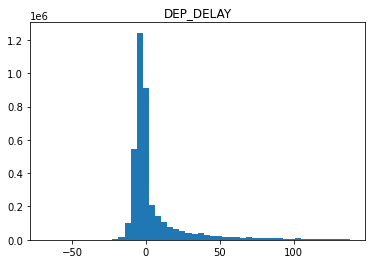

In [35]:
# flight_weather_df.hist(column='DEP_DELAY', bins =50, grid=False)

Most flights have none or minimal delays. So this distribution isn't surprising. The average flight is delayed by 9 minutes, with a fairly large standard deviation of 43 minutes. Looking at the 75th percentile, just 25% of flgiths had delays over 6 minutes.

Let's zoom in on those values.

In [44]:
# minimal = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 15, 'DEP_DELAY']
# one_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 30, 'DEP_DELAY']
# two_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 60, 'DEP_DELAY']
# three_std = flight_weather_df.loc[flight_weather_df['DEP_DELAY'] < 90, 'DEP_DELAY']

# print(minimal.count())
# print(one_std.count()- minimal.count())
# print(two_std.count()-one_std.count())
# print(three_std.count()-two_std.count())

It looks like even when we look at the most extreme 25% of delays, the average delay here is still 48 minutes with a standard deviation of 76 minutes.  Over 75% of the data falls under a 13 minute delay.

We'll construct our buckets as such:

* Neglibile delay (No delay or 15 minutes or less)
* Mild (Delay between 15 and 30 minutes)
* Moderate (Delay between 30 minutes and hour)
* Serious (Delay over an hour)
* Major (Delay over 2 hours)

In [20]:
# # Create a function to engineer this feature
# def delay_group(value):
#     """
#     Funtion takes in int or float and returns category of delay
#     """
#     if value <= 15:
#         return 'neglibile'
#     if value > 15 and value <= 60:
#         return 'moderate'
#     if value > 60:
#         return 'serious'
    
# flight_weather_df['delay_type'] = flight_weather_df['DEP_DELAY'].apply(delay_group)

# # Write the above DF to a CSV so we don't have to re-run all the code above
# flight_weather_df.to_csv('data/weather_flight_modeling_data.csv')

In [2]:
# flight_weather_df = pd.read_csv('data/weather_flight_modeling_data.csv')

In [4]:
# flight_weather_sample = flight_weather_df.sample(frac=0.01, axis=0, random_state=123)
# flight_weather_sample.to_csv('data/weather_flight_sample_data.csv', index=False)

In [2]:
flight_weather_df = pd.read_csv('data/weather_flight_sample_data.csv')

### Brining it all together

In [3]:
y = flight_weather_df["delay_type"]
X = flight_weather_df.drop(["delay_type", "DEP_DELAY", 'Unnamed: 0'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
num_cols = ['AWND',
'PRCP',
'SNOW',
'TMAX',
'TMIN',
'1hop_AWND',
'1hop_PRCP',
'1hop_SNOW',
'1hop_TMAX',
'1hop_TMIN',
'2hop_AWND',
'2hop_PRCP',
'2hop_SNOW',
'2hop_TMAX',
'2hop_TMIN',
'da_AWND',
'da_PRCP',
'da_SNOW',
'da_TMAX',
'da_TMIN',
'leg-1-distance',
'leg-2-distance',
'leg-3-distance',
'leg-1-time-diff',
'leg-2-time-diff',
'airport_2_hop_back_flight_vol_takoff',
'airport_2_hop_back_flight_vol_before_takoff',
'airport_2_hop_back_flight_vol_day_of_takoff',
'airport_1_hop_back_flight_vol_takoff',
'airport_1_hop_back_flight_vol_before_takoff',
'airport_1_hop_back_flight_vol_day_of_takoff',
'avg-flights-at-takeoff',
'avg-flights-before-takeoff',
'avg-flights-day-of-takeoff',
'takeoff-time-minutes-from-midnight',
'ELEVATION',
'SNWD',
'WDF2',
'WSF2',
'1hop_ELEVATION',
'1hop_SNWD',
'1hop_WDF2',
'1hop_WSF2',
'2hop_ELEVATION',
'2hop_SNWD',
'2hop_WDF2',
'2hop_WSF2',
'da_ELEVATION',
'da_SNWD',
'da_WDF2',
'da_WSF2']

cat_cols = ['MONTH',
'DAY_OF_WEEK',
'OP_CARRIER',
'ORIGIN',
'DEST',
'airport_1_hop_back',
'airport_2_hop_back',
'holiday',
'holiday_name',
'days-from-holiday',
'MONTH_DAY',
'op-airline-airport',
'WT01',
'WT02',
'WT03',
'WT04',
'WT05',
'WT06',
'WT07',
'WT08',
'WT09',
'WT10',
'WT18',
'1hop_WT01',
'1hop_WT02',
'1hop_WT03',
'1hop_WT04',
'1hop_WT05',
'1hop_WT06',
'1hop_WT07',
'1hop_WT08',
'1hop_WT09',
'1hop_WT10',
'1hop_WT18',
'2hop_WT01',
'2hop_WT02',
'2hop_WT03',
'2hop_WT04',
'2hop_WT05',
'2hop_WT06',
'2hop_WT07',
'2hop_WT08',
'2hop_WT09',
'2hop_WT10',
'2hop_WT18',
'da_WT01',
'da_WT02',
'da_WT03',
'da_WT04',
'da_WT05',
'da_WT06',
'da_WT07',
'da_WT08',
'da_WT09',
'da_WT10',
'da_WT18']

In [6]:
X_train_num = X_train[num_cols].copy()
X_train_cat = X_train[cat_cols].copy()

# Poly Features
# poly = PolynomialFeatures(degree=2)
# X_train_poly = poly.fit_transform(X_train_num)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_train_cat = X_train_cat.applymap(str)
cols = X_train_cat.columns

X_train_ohe = pd.get_dummies(X_train_cat,prefix=cols, drop_first=False)

In [9]:
preprocessed_data = pd.concat([X_train_ohe, X_train_scaled], axis=1)

In [75]:
X_test_num = X_test[num_cols].copy()
X_test_cat = X_test[cat_cols].copy()

# Poly Features
# poly = PolynomialFeatures(degree=2)
# X_train_poly = poly.fit_transform(X_train_num)

X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_num.index, columns=X_test_num.columns)

X_test_cat = X_test_cat.applymap(str)
cols = X_test_cat.columns

X_test_ohe = pd.get_dummies(X_test_cat,prefix=cols, drop_first=False)

preprocessed_test_data = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [6]:
# def str_transform(df):
#     df = df.applymap(str)
#     return df

In [10]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

class_weights_gd = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )
class_weights_gd = dict(zip(np.unique(y_train), class_weights_gd))

class_weights_dl = {0: class_weights_gd['moderate'],
                1: class_weights_gd['neglibile'],
                2: class_weights_gd['serious']}

In [11]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)

In [71]:
class_weights_xgb = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
class_weights_xgb = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights_xgb

array([0.39315693, 9.0209351 , 0.39315693, ..., 9.0209351 , 0.39315693,
       0.39315693])

## Modeling

In [19]:
def model_performance(pipe, X, y):
    
    scoring = ['accuracy','precision_micro', 'recall_micro', 'f1_micro']
    cv = cross_validate(pipe, X, y, return_train_score=True, scoring=scoring)
    
    # Printing Train & CV Scores
    
    print('Training Accuracy', round(cv['train_accuracy'].mean(),3))
    print('---')
    print('Cross Val Accuracy', round(cv['test_accuracy'].mean(),3))
    print('---')
    print('Training Precision:', round(cv['train_precision_micro'].mean(),3))
    print('Cross Val Precision:', round(cv['test_precision_micro'].mean(),3))
    print('---')
    print('Training Recall:', round(cv['train_recall_micro'].mean(),3))
    print('Cross Val Recall:', round(cv['test_recall_micro'].mean(),3))
    print('---')
    print('Training F1:', round(cv['train_f1_micro'].mean(),3))
    print('Cross Val F1:', round(cv['test_f1_micro'].mean(),3))
   
    # Plotting a confusion matrix
    plot_confusion_matrix(pipe, X, y, normalize='true')
    

# Function for plotting Loss & Accuracy
def visualize_training_results(hist):
    
    hist_dict = hist.history
    fig, ax = plt.subplots(figsize=(12, 8))

    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Validation loss')

    ax.set_title('Training & validation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();
    
    fig, ax = plt.subplots(figsize=(12, 8))

    acc_values = hist_dict['acc'] 
    val_acc_values = hist_dict['val_acc']

    ax.plot(epochs, acc_values, label='Training acc')
    ax.plot(epochs, val_acc_values, label='Validation acc')
    ax.set_title('Training & validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend();

In [15]:
# col_transformer = ColumnTransformer(transformers=[
#     ('str_transform', FunctionTransformer(str_transform), cat_cols),
#     ("ohe", OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore"), cat_cols),
#     ("ss", StandardScaler(), num_cols)
# ], remainder="passthrough")


# preprocessin_pipe = Pipeline(steps=[
#     ("col_transformer", col_transformer)
# ])

# preprocessed_data = preprocessin_pipe.fit_transform(X_train)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Training Accuracy 0.548
---
Cross Val Accuracy 0.526
---
Training Precision: 0.548
Cross Val Precision: 0.526
---
Training Recall: 0.548
Cross Val Recall: 0.526
---
Training F1: 0.548
Cross Val F1: 0.526


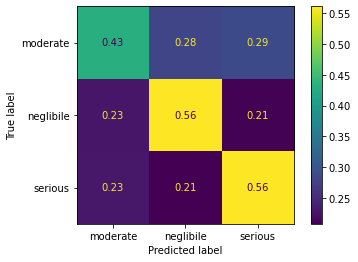

In [42]:
lr_pipe = Pipeline(steps=[
    ('lr', LogisticRegression(class_weight=class_weights_gd, random_state=123))
])

lr_pipe.fit(preprocessed_data, y_train)

model_performance(lr_pipe, preprocessed_data, y_train)

In [64]:
# lr_param_grid = {
#     'lr__solver': ['saga', 'sag', 'newton-cg'] # Trying different solvers
# }

# lr_gridsearch = GridSearchCV(estimator=lr_pipe, 
#                           param_grid=lr_param_grid,
#                           scoring='f1_micro',
#                           verbose=3)

# # Fit the training data
# lr_gridsearch.fit(X_train_preprocessed, y_train)

# # Show the best parameters
# print(lr_gridsearch.best_params_)

Training Accuracy 0.575
---
Cross Val Accuracy 0.571
---
Training Precision: 0.575
Cross Val Precision: 0.571
---
Training Recall: 0.575
Cross Val Recall: 0.571
---
Training F1: 0.575
Cross Val F1: 0.571


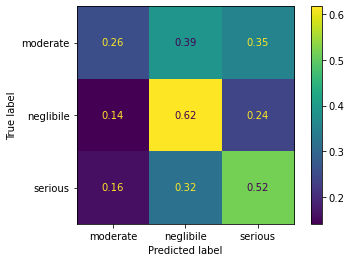

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ('rf', RandomForestClassifier(n_estimators=200,
                                  max_depth=3,
                                  class_weight=class_weights_gd,
                                  random_state=123))
])

rf_pipe.fit(preprocessed_data, y_train)

model_performance(rf_pipe, preprocessed_data, y_train)

Training Accuracy 0.866
---
Cross Val Accuracy 0.847
---
Training Precision: 0.866
Cross Val Precision: 0.847
---
Training Recall: 0.866
Cross Val Recall: 0.847
---
Training F1: 0.866
Cross Val F1: 0.847


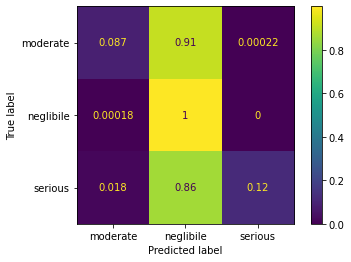

In [45]:
# Optimized XGBoost Classifier
xgb_pipe = Pipeline(steps=[
    ('xg', XGBClassifier())
])

xgb_pipe.fit(preprocessed_data, y_train)

model_performance(xgb_pipe, preprocessed_data, y_train)

Training Accuracy 0.866
---
Cross Val Accuracy 0.847
---
Training Precision: 0.866
Cross Val Precision: 0.847
---
Training Recall: 0.866
Cross Val Recall: 0.847
---
Training F1: 0.866
Cross Val F1: 0.847


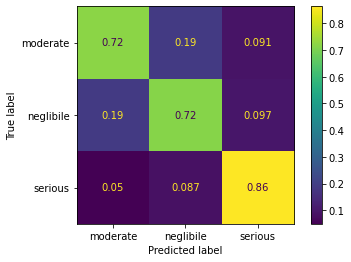

In [74]:
xg_balanced_pipe = Pipeline([
    ('my_xgb_clf', xgb.XGBClassifier()),
])

xg_balanced_pipe.fit(preprocessed_data, y_train, my_xgb_clf__sample_weight=class_weights_xgb)

model_performance(xg_balanced_pipe, preprocessed_data, y_train)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# rf_pipe2 = Pipeline(steps=[
#     ('rf', RandomForestClassifier(n_estimators=200,
#                                   max_depth=12,
#                                   class_weight=class_weights_gd,
#                                   random_state=123))
# ])

# rf_pipe2.fit(X_train_preprocessed, y_train)

# model_performance(rf_pipe2, X_train_preprocessed, y_train)

In [ ]:
# rf_pipe3 = Pipeline(steps=[
#     ('rf', RandomForestClassifier(n_estimators=200,
#                                   max_depth=16,
#                                   class_weight=class_weights_gd,
#                                   random_state=123))
# ])

# rf_pipe3.fit(X_train_preprocessed, y_train)

# model_performance(rf_pipe3, X_train_preprocessed, y_train)

## Deep Learning

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense

model_1 = Sequential()
model_1.add(Dense(1235, activation='relu', input_dim=1235))
model_1.add(Dense(600, activation='relu'))
model_1.add(Dense(300, activation='relu'))
model_1.add(Dense(150, activation='relu'))
model_1.add(Dense(75, activation='relu'))
model_1.add(Dense(3, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results_1 = model_1.fit(preprocessed_data, labels, class_weight=class_weights_dl, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
1940/1940 [==============================] - 19s 10ms/step - loss: 1.0690 - acc: 0.5322 - val_loss: 1.0033 - val_acc: 0.6431
Epoch 2/25
1940/1940 [==============================] - 19s 10ms/step - loss: 1.0385 - acc: 0.5877 - val_loss: 1.0221 - val_acc: 0.4069
Epoch 3/25
1940/1940 [==============================] - 20s 10ms/step - loss: 1.0211 - acc: 0.5778 - val_loss: 0.9607 - val_acc: 0.6137
Epoch 4/25
1940/1940 [==============================] - 19s 10ms/step - loss: 0.9857 - acc: 0.5704 - val_loss: 0.9385 - val_acc: 0.5934
Epoch 5/25
1940/1940 [==============================] - 18s 10ms/step - loss: 0.9278 - acc: 0.5736 - val_loss: 0.8816 - val_acc: 0.5823
Epoch 6/25
1940/1940 [==============================] - 19s 10ms/step - loss: 0.8277 - acc: 0.5776 - val_loss: 0.9281 - val_acc: 0.5577
Epoch 7/25
1940/1940 [==============================] - 19s 10ms/step - loss: 0.7163 - acc: 0.5949 - val_loss: 0.9805 - val_acc: 0.5544
Epoch 8/25
1940/1940 [==========================

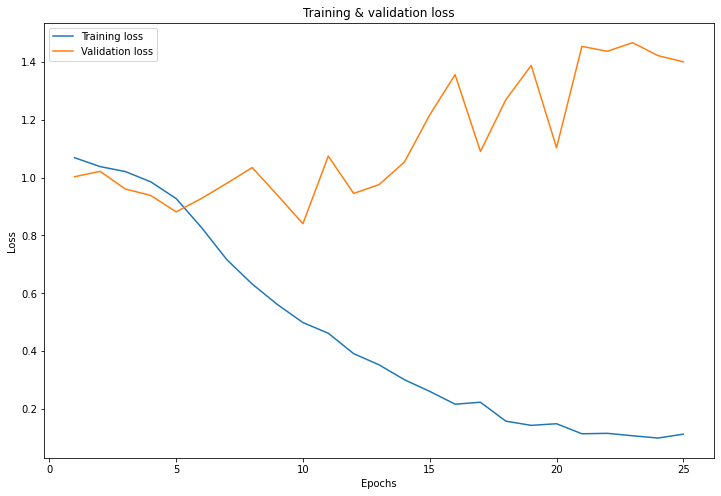

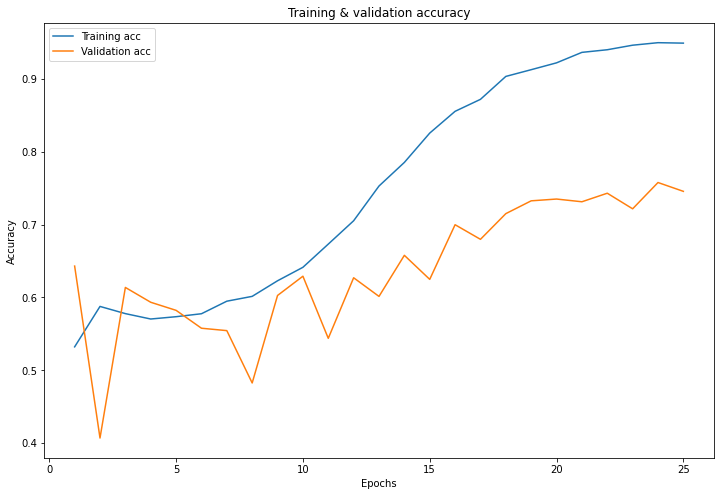

In [20]:
visualize_training_results(results_1)

In [21]:
from keras import models
from keras import layers

model_2 = Sequential()
model_2.add(Dense(1870, activation='relu', input_dim=1235))
model_2.add(Dense(935, activation='relu'))
model_2.add(Dense(300, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(Dense(150, activation='relu'))
model_2.add(Dense(75, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(Dense(3, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


model_2_hist = model_2.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_dl,
                           epochs=150,
                           batch_size=128,
                           validation_split=0.2)

Epoch 1/150
485/485 [==============================] - 10s 20ms/step - loss: 1.0729 - acc: 0.5348 - val_loss: 1.0158 - val_acc: 0.6204
Epoch 2/150
485/485 [==============================] - 9s 19ms/step - loss: 1.0403 - acc: 0.5803 - val_loss: 0.8953 - val_acc: 0.7039
Epoch 3/150
485/485 [==============================] - 9s 19ms/step - loss: 1.0174 - acc: 0.5860 - val_loss: 0.9903 - val_acc: 0.5328
Epoch 4/150
485/485 [==============================] - 9s 19ms/step - loss: 0.9826 - acc: 0.5637 - val_loss: 1.0544 - val_acc: 0.4699
Epoch 5/150
485/485 [==============================] - 9s 19ms/step - loss: 0.9160 - acc: 0.5903 - val_loss: 0.9944 - val_acc: 0.5164
Epoch 6/150
485/485 [==============================] - 9s 18ms/step - loss: 0.7934 - acc: 0.5883 - val_loss: 1.0622 - val_acc: 0.4330
Epoch 7/150
485/485 [==============================] - 9s 18ms/step - loss: 0.6663 - acc: 0.5998 - val_loss: 1.0663 - val_acc: 0.4178
Epoch 8/150
485/485 [==============================] - 9s 19m

485/485 [==============================] - 10s 21ms/step - loss: 0.0735 - acc: 0.9749 - val_loss: 1.9738 - val_acc: 0.7502
Epoch 62/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0717 - acc: 0.9781 - val_loss: 2.2888 - val_acc: 0.7732
Epoch 63/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0207 - acc: 0.9925 - val_loss: 2.7420 - val_acc: 0.7763
Epoch 64/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0166 - acc: 0.9939 - val_loss: 1.9281 - val_acc: 0.7730
Epoch 65/150
485/485 [==============================] - 9s 20ms/step - loss: 0.0311 - acc: 0.9896 - val_loss: 2.5178 - val_acc: 0.7772
Epoch 66/150
485/485 [==============================] - 10s 21ms/step - loss: 0.0136 - acc: 0.9950 - val_loss: 2.1987 - val_acc: 0.7417
Epoch 67/150
485/485 [==============================] - 10s 21ms/step - loss: 0.0293 - acc: 0.9902 - val_loss: 1.5441 - val_acc: 0.7716
Epoch 68/150
485/485 [==============================] - 10s 20

485/485 [==============================] - 11s 22ms/step - loss: 0.0305 - acc: 0.9906 - val_loss: 2.1600 - val_acc: 0.7868
Epoch 122/150
485/485 [==============================] - 10s 21ms/step - loss: 0.0233 - acc: 0.9937 - val_loss: 1.7723 - val_acc: 0.7874
Epoch 123/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0342 - acc: 0.9897 - val_loss: 2.0990 - val_acc: 0.7821
Epoch 124/150
485/485 [==============================] - 10s 21ms/step - loss: 0.0257 - acc: 0.9922 - val_loss: 1.9023 - val_acc: 0.7630
Epoch 125/150
485/485 [==============================] - 10s 21ms/step - loss: 0.0480 - acc: 0.9914 - val_loss: 1.7285 - val_acc: 0.7636
Epoch 126/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0315 - acc: 0.9915 - val_loss: 1.7240 - val_acc: 0.7764
Epoch 127/150
485/485 [==============================] - 10s 20ms/step - loss: 0.0189 - acc: 0.9961 - val_loss: 1.6957 - val_acc: 0.7703
Epoch 128/150
485/485 [==============================] 

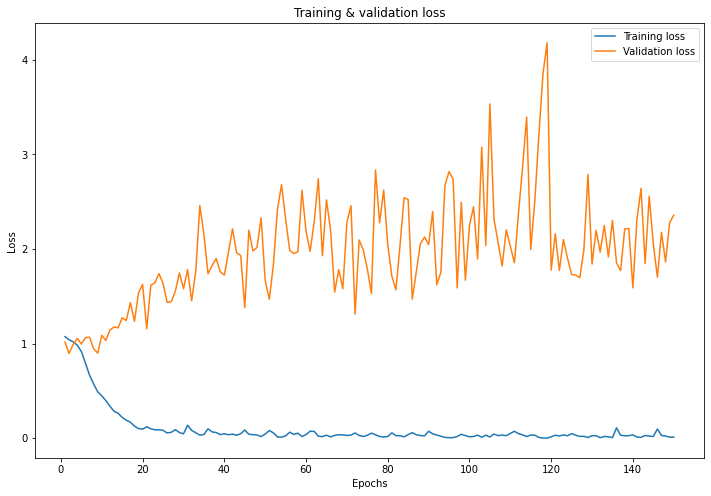

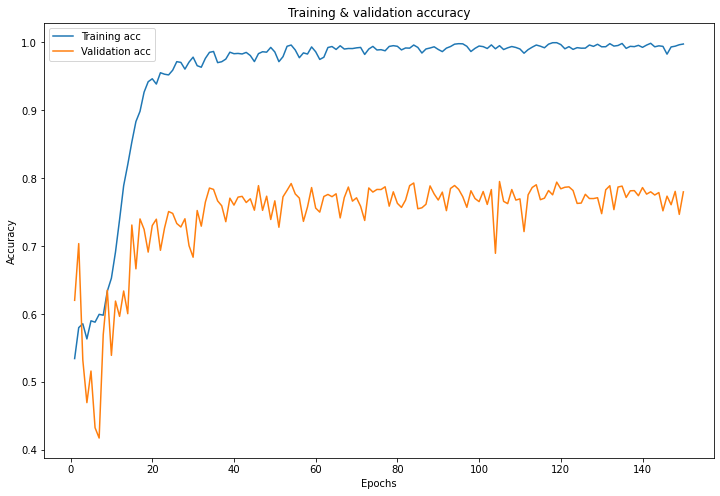

In [22]:
visualize_training_results(model_2_hist)

In [33]:
n_features = preprocessed_data.shape[1]

In [35]:
from keras import regularizers

model_3 = Sequential()
model_3.add(Dense(1870, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(n_features,)))
model_3.add(Dense(935, activation='relu'))
model_3.add(Dense(300, activation='relu'))
model_3.add(Dense(150, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_3.add(Dense(75, activation='relu'))
model_3.add(Dense(3, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [36]:
model_3_hist = model_3.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_dl,
                           epochs=150,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/150
1940/1940 [==============================] - 42s 22ms/step - loss: 1.4145 - acc: 0.5359 - val_loss: 1.0441 - val_acc: 0.5863
Epoch 2/150
1940/1940 [==============================] - 41s 21ms/step - loss: 1.0714 - acc: 0.5557 - val_loss: 0.9495 - val_acc: 0.7311
Epoch 3/150
1940/1940 [==============================] - 42s 21ms/step - loss: 1.0655 - acc: 0.5779 - val_loss: 1.1268 - val_acc: 0.4497
Epoch 4/150
1940/1940 [==============================] - 41s 21ms/step - loss: 1.0614 - acc: 0.5613 - val_loss: 1.0826 - val_acc: 0.5160
Epoch 5/150
1940/1940 [==============================] - 40s 21ms/step - loss: 1.0610 - acc: 0.5716 - val_loss: 1.0925 - val_acc: 0.5198
Epoch 6/150
1940/1940 [==============================] - 41s 21ms/step - loss: 1.0580 - acc: 0.5691 - val_loss: 1.0419 - val_acc: 0.5833
Epoch 7/150
1940/1940 [==============================] - 41s 21ms/step - loss: 1.0567 - acc: 0.5780 - val_loss: 0.9266 - val_acc: 0.6283
Epoch 8/150
1940/1940 [==================

1940/1940 [==============================] - 38s 20ms/step - loss: 1.0499 - acc: 0.5811 - val_loss: 1.0554 - val_acc: 0.5226
Epoch 61/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0498 - acc: 0.5743 - val_loss: 0.9493 - val_acc: 0.5999
Epoch 62/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0495 - acc: 0.5678 - val_loss: 0.8907 - val_acc: 0.6805
Epoch 63/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0509 - acc: 0.5713 - val_loss: 1.0110 - val_acc: 0.5937
Epoch 64/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0499 - acc: 0.5769 - val_loss: 1.0805 - val_acc: 0.5098
Epoch 65/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0498 - acc: 0.5730 - val_loss: 1.0417 - val_acc: 0.5488
Epoch 66/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0500 - acc: 0.5759 - val_loss: 1.0482 - val_acc: 0.5414
Epoch 67/150
1940/1940 [=======================

1940/1940 [==============================] - 38s 20ms/step - loss: 1.0503 - acc: 0.5791 - val_loss: 1.0851 - val_acc: 0.4908
Epoch 120/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0492 - acc: 0.5700 - val_loss: 0.9530 - val_acc: 0.6145
Epoch 121/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0503 - acc: 0.5766 - val_loss: 1.0257 - val_acc: 0.5657
Epoch 122/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0503 - acc: 0.5640 - val_loss: 0.9656 - val_acc: 0.6458
Epoch 123/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0503 - acc: 0.5703 - val_loss: 1.0958 - val_acc: 0.4908
Epoch 124/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0496 - acc: 0.5896 - val_loss: 0.9659 - val_acc: 0.6275
Epoch 125/150
1940/1940 [==============================] - 38s 20ms/step - loss: 1.0496 - acc: 0.5879 - val_loss: 1.0985 - val_acc: 0.4880
Epoch 126/150
1940/1940 [================

In [37]:
model_4 = Sequential()
model_4.add(Dense(1870, kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(n_features,)))
model_4.add(Dense(935, activation='relu'))
model_4.add(Dense(300, activation='relu'))
model_4.add(Dense(150, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(3, activation='softmax'))

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model_4_hist = model_4.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_dl,
                           epochs=150,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/150
1940/1940 [==============================] - 39s 20ms/step - loss: 1.2570 - acc: 0.5295 - val_loss: 1.0100 - val_acc: 0.6104
Epoch 2/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0750 - acc: 0.5796 - val_loss: 0.9979 - val_acc: 0.6261
Epoch 3/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0650 - acc: 0.5776 - val_loss: 1.1545 - val_acc: 0.4801
Epoch 4/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0611 - acc: 0.5743 - val_loss: 0.9393 - val_acc: 0.6387
Epoch 5/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0596 - acc: 0.5477 - val_loss: 1.0749 - val_acc: 0.4711
Epoch 6/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0583 - acc: 0.5616 - val_loss: 0.8972 - val_acc: 0.6669
Epoch 7/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0561 - acc: 0.5565 - val_loss: 0.9939 - val_acc: 0.6214
Epoch 8/150
1940/1940 [==================

1940/1940 [==============================] - 38s 19ms/step - loss: 1.0508 - acc: 0.5721 - val_loss: 1.0260 - val_acc: 0.5565
Epoch 61/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0504 - acc: 0.5778 - val_loss: 0.9573 - val_acc: 0.6616
Epoch 62/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0508 - acc: 0.5775 - val_loss: 0.8947 - val_acc: 0.6856
Epoch 63/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0487 - acc: 0.5727 - val_loss: 1.1046 - val_acc: 0.4777
Epoch 64/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0515 - acc: 0.5569 - val_loss: 1.0668 - val_acc: 0.5160
Epoch 65/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0507 - acc: 0.5731 - val_loss: 1.0192 - val_acc: 0.5638
Epoch 66/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0516 - acc: 0.5714 - val_loss: 1.0426 - val_acc: 0.5741
Epoch 67/150
1940/1940 [=======================

1940/1940 [==============================] - 38s 20ms/step - loss: 1.0492 - acc: 0.5576 - val_loss: 1.0324 - val_acc: 0.5586
Epoch 120/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0501 - acc: 0.5752 - val_loss: 0.9769 - val_acc: 0.6088
Epoch 121/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0499 - acc: 0.5766 - val_loss: 0.9221 - val_acc: 0.6609
Epoch 122/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0499 - acc: 0.5676 - val_loss: 0.9863 - val_acc: 0.5850
Epoch 123/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0503 - acc: 0.5671 - val_loss: 1.0637 - val_acc: 0.5095
Epoch 124/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0508 - acc: 0.5734 - val_loss: 1.0555 - val_acc: 0.5194
Epoch 125/150
1940/1940 [==============================] - 38s 19ms/step - loss: 1.0508 - acc: 0.5619 - val_loss: 1.0141 - val_acc: 0.5787
Epoch 126/150
1940/1940 [================

In [38]:
model_5 = Sequential()
model_5.add(Dense(1870, kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(0.005), activation='relu', input_shape=(n_features,)))
model_5.add(Dense(935, activation='relu'))
model_5.add(Dense(300, activation='relu'))
model_5.add(Dense(150, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_5.add(Dense(75, activation='relu'))
model_5.add(Dense(3, activation='softmax'))

model_5.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc'])

model_5_hist = model_5.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_dl,
                           epochs=150,
                           batch_size=32,
                           validation_split=0.2)

Epoch 1/150
1940/1940 [==============================] - 33s 17ms/step - loss: 9.6459 - acc: 0.5053 - val_loss: 8.1859 - val_acc: 0.4339
Epoch 2/150
1940/1940 [==============================] - 31s 16ms/step - loss: 6.8678 - acc: 0.5632 - val_loss: 5.8080 - val_acc: 0.5501
Epoch 3/150
1940/1940 [==============================] - 31s 16ms/step - loss: 4.9896 - acc: 0.5631 - val_loss: 4.2302 - val_acc: 0.5888
Epoch 4/150
1940/1940 [==============================] - 31s 16ms/step - loss: 3.7161 - acc: 0.5664 - val_loss: 3.0856 - val_acc: 0.6573
Epoch 5/150
1940/1940 [==============================] - 31s 16ms/step - loss: 2.8535 - acc: 0.5639 - val_loss: 2.3194 - val_acc: 0.6879
Epoch 6/150
1940/1940 [==============================] - 31s 16ms/step - loss: 2.2719 - acc: 0.5688 - val_loss: 2.1186 - val_acc: 0.4618
Epoch 7/150
1940/1940 [==============================] - 31s 16ms/step - loss: 1.8740 - acc: 0.5676 - val_loss: 1.9322 - val_acc: 0.3036
Epoch 8/150
1940/1940 [==================

1940/1940 [==============================] - 31s 16ms/step - loss: 1.0209 - acc: 0.5686 - val_loss: 1.1593 - val_acc: 0.5675
Epoch 61/150
1940/1940 [==============================] - 32s 16ms/step - loss: 1.0096 - acc: 0.5772 - val_loss: 1.2548 - val_acc: 0.5580
Epoch 62/150
1940/1940 [==============================] - 30s 16ms/step - loss: 1.0012 - acc: 0.5803 - val_loss: 1.3047 - val_acc: 0.4898
Epoch 63/150
1940/1940 [==============================] - 31s 16ms/step - loss: 0.9980 - acc: 0.5829 - val_loss: 1.1084 - val_acc: 0.6301
Epoch 64/150
1940/1940 [==============================] - 30s 15ms/step - loss: 0.9886 - acc: 0.5882 - val_loss: 1.1953 - val_acc: 0.5673
Epoch 65/150
1940/1940 [==============================] - 30s 15ms/step - loss: 0.9967 - acc: 0.5824 - val_loss: 1.0449 - val_acc: 0.6960
Epoch 66/150
1940/1940 [==============================] - 31s 16ms/step - loss: 0.9882 - acc: 0.5913 - val_loss: 1.4799 - val_acc: 0.4136
Epoch 67/150
1940/1940 [=======================

1940/1940 [==============================] - 33s 17ms/step - loss: 0.7881 - acc: 0.7085 - val_loss: 1.1836 - val_acc: 0.6816
Epoch 120/150
1940/1940 [==============================] - 34s 17ms/step - loss: 0.7736 - acc: 0.7217 - val_loss: 1.6965 - val_acc: 0.4352
Epoch 121/150
1940/1940 [==============================] - 34s 17ms/step - loss: 0.7634 - acc: 0.7248 - val_loss: 1.3033 - val_acc: 0.5969
Epoch 122/150
1940/1940 [==============================] - 33s 17ms/step - loss: 0.7646 - acc: 0.7300 - val_loss: 1.1922 - val_acc: 0.6810
Epoch 123/150
1940/1940 [==============================] - 34s 18ms/step - loss: 0.7779 - acc: 0.7175 - val_loss: 1.4442 - val_acc: 0.5160
Epoch 124/150
1940/1940 [==============================] - 34s 18ms/step - loss: 0.7597 - acc: 0.7316 - val_loss: 1.1686 - val_acc: 0.7275
Epoch 125/150
1940/1940 [==============================] - 34s 18ms/step - loss: 0.7607 - acc: 0.7273 - val_loss: 1.2590 - val_acc: 0.6326
Epoch 126/150
1940/1940 [================

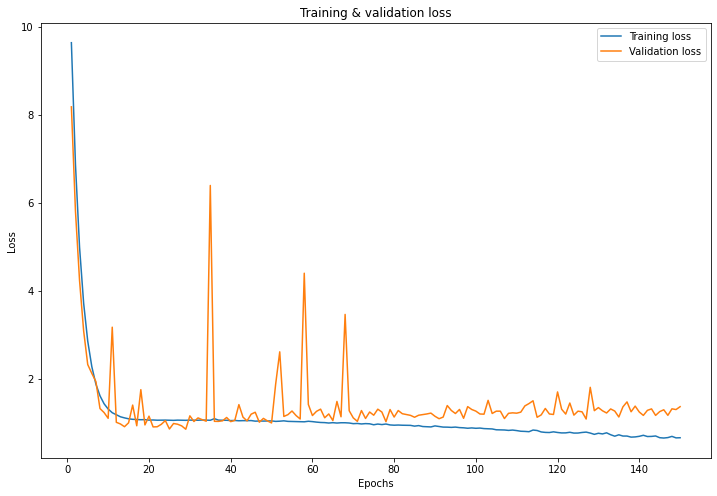

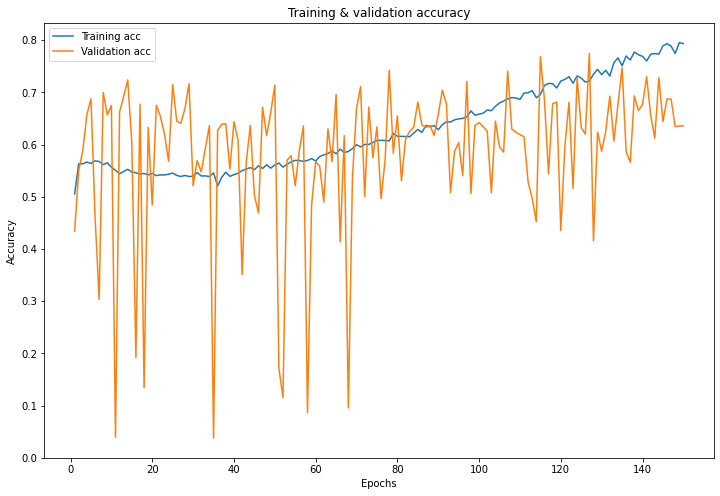

In [40]:
visualize_training_results(model_5_hist)

In [39]:
model_6 = Sequential()
model_6.add(layers.Dropout(0.3))
model_6.add(Dense(1870, activation='relu', input_shape=(n_features,)))
model_6.add(Dense(935, activation='relu'))
model_6.add(layers.Dropout(0.3))
model_6.add(Dense(300, activation='relu'))
model_6.add(Dense(150, activation='relu'))
model_6.add(Dense(75, activation='relu'))
model_6.add(layers.Dropout(0.3))
model_6.add(Dense(3, activation='softmax'))

model_6.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc'])

model_6_hist = model_6.fit(preprocessed_data,
                           labels,
                           class_weight=class_weights_dl,
                           epochs=150,
                           batch_size=256,
                           validation_split=0.2)

Epoch 1/150
243/243 [==============================] - 7s 28ms/step - loss: 1.1001 - acc: 0.2781 - val_loss: 1.0553 - val_acc: 0.6870
Epoch 2/150
243/243 [==============================] - 6s 25ms/step - loss: 1.0900 - acc: 0.3935 - val_loss: 1.0403 - val_acc: 0.6475
Epoch 3/150
243/243 [==============================] - 6s 25ms/step - loss: 1.0835 - acc: 0.4674 - val_loss: 1.0188 - val_acc: 0.6547
Epoch 4/150
243/243 [==============================] - 6s 25ms/step - loss: 1.0779 - acc: 0.5240 - val_loss: 1.0073 - val_acc: 0.6262
Epoch 5/150
243/243 [==============================] - 6s 26ms/step - loss: 1.0733 - acc: 0.5384 - val_loss: 1.0066 - val_acc: 0.6310
Epoch 6/150
243/243 [==============================] - 6s 26ms/step - loss: 1.0700 - acc: 0.5466 - val_loss: 1.0370 - val_acc: 0.5724
Epoch 7/150
243/243 [==============================] - 6s 26ms/step - loss: 1.0675 - acc: 0.5494 - val_loss: 0.9927 - val_acc: 0.6243
Epoch 8/150
243/243 [==============================] - 7s 28ms

Epoch 62/150
243/243 [==============================] - 7s 28ms/step - loss: 0.9896 - acc: 0.5184 - val_loss: 1.0134 - val_acc: 0.4980
Epoch 63/150
243/243 [==============================] - 7s 27ms/step - loss: 0.9945 - acc: 0.5148 - val_loss: 1.0323 - val_acc: 0.4940
Epoch 64/150
243/243 [==============================] - 7s 27ms/step - loss: 0.9901 - acc: 0.5213 - val_loss: 0.9308 - val_acc: 0.5776
Epoch 65/150
243/243 [==============================] - 7s 27ms/step - loss: 0.9888 - acc: 0.5187 - val_loss: 0.8438 - val_acc: 0.6634
Epoch 66/150
243/243 [==============================] - 7s 27ms/step - loss: 0.9923 - acc: 0.5264 - val_loss: 0.9931 - val_acc: 0.5272
Epoch 67/150
243/243 [==============================] - 6s 27ms/step - loss: 0.9793 - acc: 0.5259 - val_loss: 1.0336 - val_acc: 0.4839
Epoch 68/150
243/243 [==============================] - 7s 27ms/step - loss: 0.9776 - acc: 0.5237 - val_loss: 0.8329 - val_acc: 0.6384
Epoch 69/150
243/243 [==============================] -

243/243 [==============================] - 6s 25ms/step - loss: 0.8352 - acc: 0.5399 - val_loss: 1.0336 - val_acc: 0.4806
Epoch 123/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8303 - acc: 0.5384 - val_loss: 0.9649 - val_acc: 0.5123
Epoch 124/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8302 - acc: 0.5370 - val_loss: 0.9326 - val_acc: 0.5118
Epoch 125/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8160 - acc: 0.5367 - val_loss: 0.8211 - val_acc: 0.6224
Epoch 126/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8132 - acc: 0.5422 - val_loss: 1.0188 - val_acc: 0.5031
Epoch 127/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8051 - acc: 0.5463 - val_loss: 0.9865 - val_acc: 0.5038
Epoch 128/150
243/243 [==============================] - 6s 25ms/step - loss: 0.8150 - acc: 0.5404 - val_loss: 0.9434 - val_acc: 0.5507
Epoch 129/150
243/243 [==============================] - 6s 25

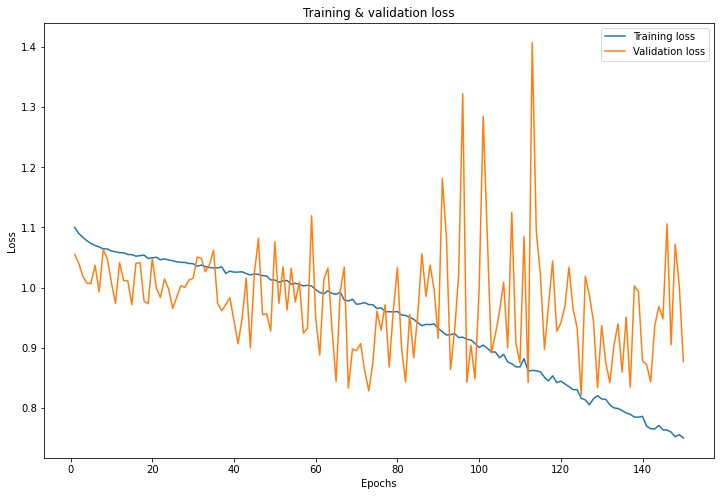

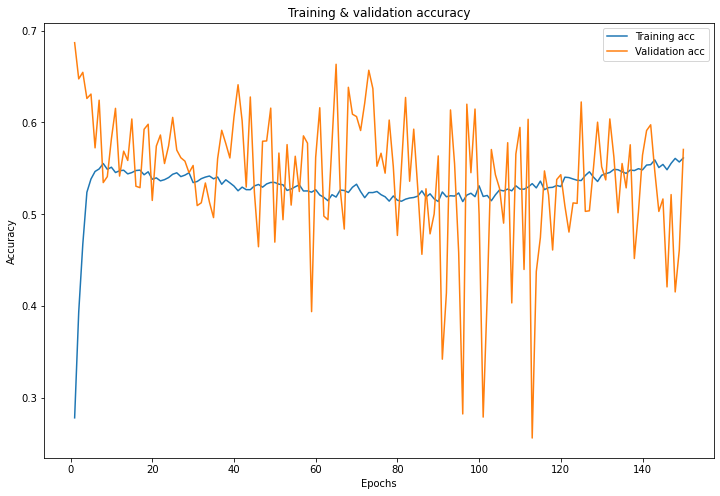

In [41]:
visualize_training_results(model_6_hist)

In [ ]:
# # Searching for the best hyperparameters
# xgb_grid = {
#     'xg__learning_rate': [0.05, 0.10, 0.15],
#     'xg__max_depth': [3, 6, 12, 15],
#     'xg__min_child_weight': [1, 3, 5, 7],
#     'xg__subsample': [0.5, 0.7]
# }

# args = {'sample_weight': sample_weights}

# xgb_pipe = Pipeline(steps=[
#     ('xg', XGBClassifier(**args))
# ])

# xgb_gridsearch = GridSearchCV(estimator=xgb_pipe, 
#                           param_grid=xgb_grid,
#                           scoring='recall',
#                           verbose=3,
#                           error_score="raise")

# # Fit the training data
# xgb_gridsearch.fit(X_train_preprocessed, y_train)

# # Print the recall on test set and best params
# print(xgb_gridsearch.best_params_)